In [52]:
import scanpy as sc
import squidpy as sq
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bin import load_bgi as ld

In [2]:
cdata = ld.load_bin(gem_file="gRNA/B924/D03658A3-merged.gem.bin_100",
                        bin_size=1,
                        library_id="gRNA")
cdata

AnnData object with n_obs × n_vars = 21883 × 68
    obsm: 'spatial'

In [7]:
fdata = ad.read_h5ad("./RNA/Multitime_sorted.h5")
fdata = fdata[fdata.obs["time_point"] == "1"]

In [22]:
g_cells = [tuple(array) for array in cdata.obsm["spatial"]]
t_cells = [tuple(array) for array in fdata.obsm['spatial']]
cells_to_keep = [True if cell in t_cells else False for cell in g_cells]
cells_to_add = np.array([cell for cell in t_cells if cell not in g_cells])

cgdata = cdata[cells_to_keep, :].copy()

s = len(cells_to_add)
new_data = np.zeros((s, cdata.n_vars))
new_obs = pd.DataFrame(index=[f'new_{i}' for i in range(s)])
new_adata = ad.AnnData(new_data, var=cgdata.var.copy(), obs=new_obs)
new_adata.obsm['spatial'] = np.array([[array[0], array[1]] for array in cells_to_add])

gdata = cgdata.concatenate(new_adata, join='outer', index_unique=None)

In [37]:
gdata.obs["spatial_cov"] = np.array([f"{array[0]}" + f"{array[1]}" for array in gdata.obsm['spatial']])
fdata.obs["spatial_cov"] = np.array([f"{array[0]}" + f"{array[1]}" for array in fdata.obsm['spatial']])

/tmp/ipykernel_54734/3323009528.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  fdata.obs["spatial_cov"] = np.array([f"{array[0]}" + f"{array[1]}" for array in fdata.obsm['spatial']])


In [38]:
sorted_indices = sorted(enumerate(gdata.obs["spatial_cov"]), key=lambda x: x[1])
indexes = [orig_idx for orig_idx, _ in sorted_indices]
sorted_cdata = gdata[indexes, :].copy()
sorted_indices = sorted(enumerate(fdata.obs["spatial_cov"]), key=lambda x: x[1])
indexes = [orig_idx for orig_idx, _ in sorted_indices]
sorted_fdata = fdata[indexes, :].copy()

In [39]:
[(a[0] == b[0]) & (a[1] == b[1]) for a, b in zip(sorted_cdata.obsm["spatial"], sorted_fdata.obsm["spatial"])] == [True] * 20587

True

In [102]:
sorted_cdata.obs["cluster_cellcharter_givenk"] = sorted_fdata.obs["cluster_cellcharter_givenk"].tolist()
sorted_cdata.obs["sgNTC"] = sorted_cdata[:, "sgnon-targeting_1_gene"].X.toarray() + sorted_cdata[:, "sgnon-targeting_2_gene"].X.toarray()
ntc_df = sorted_cdata.obs[["sgNTC", "cluster_cellcharter_givenk"]]
ntc_df = ntc_df.groupby(["cluster_cellcharter_givenk"]).sum().T
ntc_vec = ntc_df.loc["sgNTC"].tolist()
ntc_vec = ntc_vec / np.sum(ntc_vec)

In [103]:
# proportion matrix for each gene and cluster


guide_cluster_counts = pd.DataFrame(sorted_cdata[:,:-2].X.toarray())
guide_cluster_counts.columns = sorted_cdata.var_names[:-2]
guide_cluster_counts["cluster"] = sorted_cdata.obs["cluster_cellcharter_givenk"].tolist()

guide_total_counts = guide_cluster_counts.sum(axis=0)
guide_cluster_proportions = guide_cluster_counts.groupby(["cluster"]).sum()
guide_cluster_proportions = guide_cluster_proportions.div(guide_total_counts, axis=1)
guide_cluster_proportions.index = guide_cluster_proportions.index.astype(int)
guide_cluster_proportions = guide_cluster_proportions.T.reindex(sorted(guide_cluster_proportions.index), axis=1)
for i in range(12): guide_cluster_proportions[i] = guide_cluster_proportions.convert_dtypes().loc[:, i].astype(float).to_list()
guide_cluster_proportions = guide_cluster_proportions[1:]
guide_cluster_proportions = guide_cluster_proportions - ntc_vec

In [124]:
guide_cluster_proportions.index = guide_cluster_proportions.index.str.rstrip('_gene')

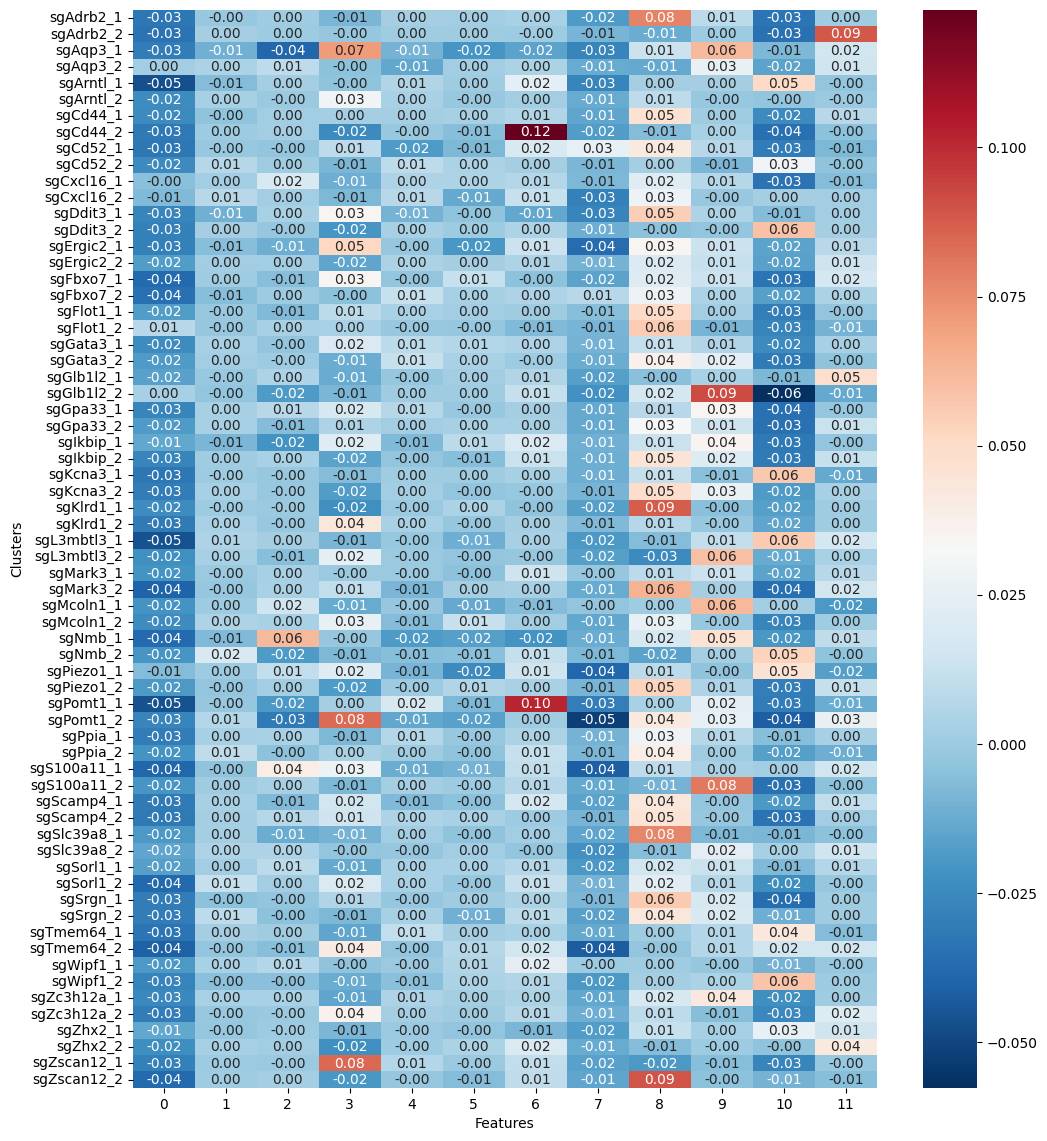

In [139]:
plt.figure(figsize=(12,14))
sns.heatmap(guide_cluster_proportions, annot=True, fmt=".2f", cmap="RdBu_r")

plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()